+-------------+-----------+------------------+---------------+---------------------------+
|  region_name|time_period|sum(sess_possible)|sum(enrolments)|pupil_attendance_percentage|
+-------------+-----------+------------------+---------------+---------------------------+
|         NULL|     200607|        3887983296|       13164850|          0.338603563794735|
|         NULL|     200708|        3795635654|       12956306|         0.3413474627456959|
|         NULL|     200809|        3759454810|       12817086|        0.34092938066197953|
|         NULL|     200910|        3776725878|       12775368|         0.3382656939551386|
|         NULL|     201011|        3753717200|       12765670|         0.3400807604792391|
|         NULL|     201112|        3890599086|       12822166|        0.32956790757853993|
|         NULL|     201213|        4564482586|       12955450|         0.2838317324232202|
|         NULL|     201314|        4616588304|       13108014|        0.28393292052147434|

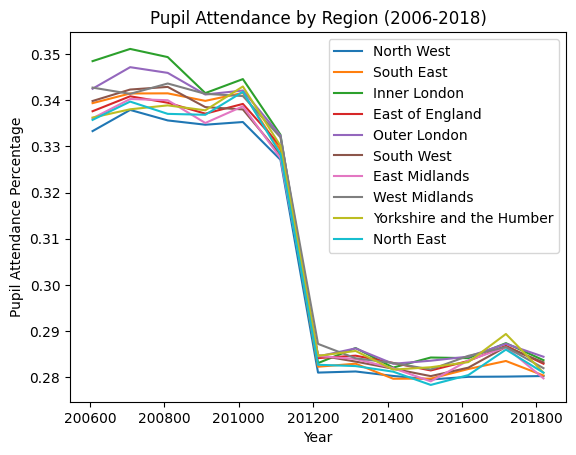

In [52]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Create a Spark session
spark = SparkSession.builder.appName("P1").getOrCreate()

# Read the CSV file
df = spark.read.csv("data/Absence_3term201819_nat_reg_la_sch.csv", header=True, inferSchema=True)
# print(df.show())
# print(df.columns)
# df.printSchema()

# Allow the user to search the dataset by local authority
def search_by_local_authority(local_authorities):
    # Filter the dataset by the given local authorities
    filtered_df = df.filter(col("la_name").isin(local_authorities))
    
    # Group the filtered dataset by time_period (year) and la_name (local authority)
    grouped_df = filtered_df.groupBy("time_period", "la_name").agg({"enrolments": "sum"})
    
    # Rename the columns for better readability
    grouped_df = grouped_df.withColumnRenamed("sum(enrolments)", "total_enrolments")
    
    # Show the number of pupil enrolments in each local authority by time period (year)
    grouped_df.show()

# search_by_local_authority(["Manchester"])

def search_by_school_type(school_type):
    # Filter the dataset for the years 2017 and 2018
    filtered_df = df.filter((col("time_period").like("%2017%")) | (col("time_period").like("%2018%")))

    # Filter the dataset by school_type and authorised absences due to illness or medical appointments
    filtered_df = filtered_df.filter((col("school_type") == school_type) & (col("sess_auth_illness").isNotNull()))

    # Get the sum of authorised absences due to illness or medical appointments
    total = filtered_df.agg({"sess_auth_illness": "sum"}).collect()[0][0]
    print(total)

# search_by_school_type("Total")

# Allow the user to search for all unauthorised absences in a certain year, broken down by either region name or local authority name
def search_unauthorised_absences(year, breakdown_by):
    # Filter the dataset for the given year
    filtered_df = df.filter(col("time_period").like(f"%{year}%"))

    # Group the filtered dataset by the specified breakdown column (region_name or la_name)
    grouped_df = filtered_df.groupBy(breakdown_by).agg({"sess_unauthorised": "sum"})

    # Rename the columns for better readability
    grouped_df = grouped_df.withColumnRenamed("sum(sess_unauthorised)", "total_unauthorised_absences")

    # Show the results
    grouped_df.show()

# search_unauthorised_absences(2018, "la_name")

# Example usage: search for all unauthorised absences in 2017, broken down by local authority name
# search_unauthorised_absences(2017, "la_name")

# Allow the user to search for all unauthorised absences in a certain year, broken down by either region name or local authority name
def search_top_3_reasons(year):
    # Filter the dataset for the given year
    filtered_df = df.filter(col("time_period").like(f"%{year}%"))

    # Group the filtered dataset by the reasons for authorised absences and sum up the counts
    grouped_df = filtered_df.groupBy("sess_auth_totalreasons").agg({"sess_auth_totalreasons": "count"})

    # Rename the columns for better readability
    grouped_df = grouped_df.withColumnRenamed("count(sess_auth_totalreasons)", "total_reasons")

    # Sort the DataFrame by the total reasons in descending order
    sorted_df = grouped_df.sort(col("total_reasons").desc())

    # Show the top 3 reasons for authorised absences in the given year
    sorted_df.show(3)

# search_top_3_reasons(2018)
# search_top_3_reasons(2017)

# Allow the user to search for all unauthorised absences in a certain year, broken down by either region name or local authority name
def compare_local_authorities(local_authority1, local_authority2, year):
    # Filter the dataset for the given year and the two local authorities
    filtered_df = df.filter((col("time_period").like(f"%{year}%")) & ((col("la_name") == local_authority1) | (col("la_name") == local_authority2)))

    # Group the filtered dataset by local authority and sum up the number of pupils
    grouped_df = filtered_df.groupBy("la_name").agg({"enrolments": "sum"})

    # Rename the columns for better readability
    grouped_df = grouped_df.withColumnRenamed("sum(enrolments)", "total_pupils")

    # Show the comparison between the two local authorities
    grouped_df.show()

# compare_local_authorities("Manchester", "Birmingham", 2018)

# Allow the user to search for all unauthorised absences in a certain year, broken down by either region name or local authority name
def explore_region_performance():
    # Filter the dataset for the years 2006 to 2018
    filtered_df = df.filter((col("time_period").like("%2006%")) | (col("time_period").like("%2007%")) | (col("time_period").like("%2008%")) | (col("time_period").like("%2009%")) | (col("time_period").like("%2010%")) | (col("time_period").like("%2011%")) | (col("time_period").like("%2012%")) | (col("time_period").like("%2013%")) | (col("time_period").like("%2014%")) | (col("time_period").like("%2015%")) | (col("time_period").like("%2016%")) | (col("time_period").like("%2017%")) | (col("time_period").like("%2018%")))

    # Group the filtered dataset by region and calculate the percentage of pupil attendance for each year
    grouped_df = filtered_df.groupBy("region_name", "time_period").agg({"enrolments": "sum", "sess_possible": "sum"})
    grouped_df = grouped_df.withColumn("pupil_attendance_percentage", (col("sum(enrolments)") / col("sum(sess_possible)")) * 100)

    # Sort the DataFrame by region and year
    sorted_df = grouped_df.sort(col("region_name"), col("time_period"))

    # Show the results
    sorted_df.show()

    # Plot the results
    regions = sorted_df.select("region_name").distinct().rdd.flatMap(lambda x: x).collect()
    for region in regions:
        region_df = sorted_df.filter(col("region_name") == region)
        years = region_df.select("time_period").rdd.flatMap(lambda x: x).collect()
        attendance_percentages = region_df.select("pupil_attendance_percentage").rdd.flatMap(lambda x: x).collect()
        plt.plot(years, attendance_percentages, label=region)

    plt.xlabel("Year")
    plt.ylabel("Pupil Attendance Percentage")
    plt.title("Pupil Attendance by Region (2006-2018)")
    plt.legend()
    plt.show()

explore_region_performance()

# df.write.mode("overwrite").csv("output/pupil_absence.parquet")

spark.stop()
